In [1]:
!pip install tensorflow-ranking
!pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.datasets import dump_svmlight_file
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import KNNImputer
from sklearn.model_selection import GroupShuffleSplit

from sklearn.metrics import ndcg_score

import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_ranking as tfr

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pd.set_option('display.max_columns', None)

In [205]:
df_amenities = pd.read_csv('/content/drive/My Drive/Expedia/Data/exploded_df_100Krows_Top500Destinations__LeftJoin_Amenities_NaHandled_17April.csv')

In [206]:
for i,j in df_amenities.iterrows():
  if (j['num_clicks'] > 0) & (j['is_trans'] == 0):
    df_amenities.at[i,'relevance'] = 1
  elif (j['num_clicks'] > 0) & (j['is_trans'] > 0):
    df_amenities.at[i,'relevance'] = 2
  else:
    df_amenities.at[i,'relevance'] = 0

df_amenities['relevance'].value_counts()

relevance
0.0    195442
1.0     13546
2.0       993
Name: count, dtype: int64

In [343]:
fil_df = df_amenities.groupby('search_id', as_index=False).agg({'relevance':'sum'})
fil_df

,search_id,relevance
0,2,1.0
1,45,1.0
2,47,1.0
3,50,3.0
4,51,5.0
...,...,...
7734,99867,1.0
7735,99870,5.0
7736,99875,10.0
7737,99880,1.0


In [342]:
0/4

0.0

In [ ]:
df_amenities

In [344]:
for i,j in df_amenities.iterrows():
  df_amenities.at[i,'relevance'] = df_amenities.loc[i,'relevance'] / fil_df[fil_df['search_id'] == df_amenities.loc[i,'search_id']]['relevance']

<ipython-input-344-f4c677d8c158>:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df_amenities.at[i,'relevance'] = df_amenities.loc[i,'relevance'] / fil_df[fil_df['search_id'] == df_amenities.loc[i,'search_id']]['relevance']


In [345]:
df_amenities[df_amenities['search_id'] == 99875]['relevance']

209894    0.0
209895    0.0
209896    0.0
209897    0.2
209898    0.1
209899    0.0
209900    0.0
209901    0.0
209902    0.0
209903    0.0
209904    0.1
209905    0.0
209906    0.0
209907    0.0
209908    0.0
209909    0.1
209910    0.0
209911    0.0
209912    0.0
209913    0.0
209914    0.1
209915    0.0
209916    0.0
209917    0.0
209918    0.1
209919    0.1
209920    0.0
209921    0.1
209922    0.0
209923    0.1
Name: relevance, dtype: float64

In [207]:
#grouped_df = df_amenities.groupby('search_id').agg({'relevance':'sum'})
#f_df = grouped_df[grouped_df['relevance'] >1]

In [208]:
#f_df.index

In [209]:
#df_amenities = df_amenities[df_amenities['search_id'].isin(f_df.index)]

In [346]:
df_amenities.head()

,user_id,search_id,point_of_sale,geo_location_country,is_mobile,destination_id,checkin_date,checkout_date,adult_count,child_count,infant_count,room_count,sort_type,length_of_stay,booking_window,search_day_of_week,search_hour_of_day,checkin_day,checkout_day,rank,prop_id,is_travel_ad,review_rating,review_count,star_rating,is_free_cancellation,is_drr,price_bucket,num_clicks,is_trans,rank_noad,AirConditioning,AirportTransfer,Bar,FreeAirportTransportation,FreeBreakfast,FreeParking,FreeWiFi,Gym,HighSpeedInternet,HotTub,LaundryFacility,Parking,PetsAllowed,PrivatePool,SpaServices,SwimmingPool,WasherDryer,WiFi,relevance
0,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,0,1,RECOMMENDED,5.0,26.0,3,0,2,2,1,1624072,0,4.0,1250.0,4.0,1,1,2.0,1,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,0,1,RECOMMENDED,5.0,26.0,3,0,2,2,2,5170759,1,4.0,1025.0,3.0,0,0,1.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,0,1,RECOMMENDED,5.0,26.0,3,0,2,2,3,1342604,1,4.0,1375.0,4.0,1,1,4.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,0,1,RECOMMENDED,5.0,26.0,3,0,2,2,4,5866319,0,4.0,2225.0,4.0,1,1,1.0,0,0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,0,1,RECOMMENDED,5.0,26.0,3,0,2,2,5,2935403,0,5.0,1050.0,4.0,1,1,2.0,0,0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [347]:
def split_by_qid(df2, test_size):
    gss = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=42)
    ids = df2['search_id'].unique()
    train_idx, test_idx = next(gss.split(ids, groups=ids))
    return df2[df2['search_id'].isin(ids[train_idx])], df2[df2['search_id'].isin(ids[test_idx])]

train_df, temp_df = split_by_qid(df_amenities, test_size=0.4)
val_df, test_df = split_by_qid(temp_df, test_size=0.5)

train_df.shape, val_df.shape, test_df.shape

((126060, 50), (42075, 50), (41846, 50))

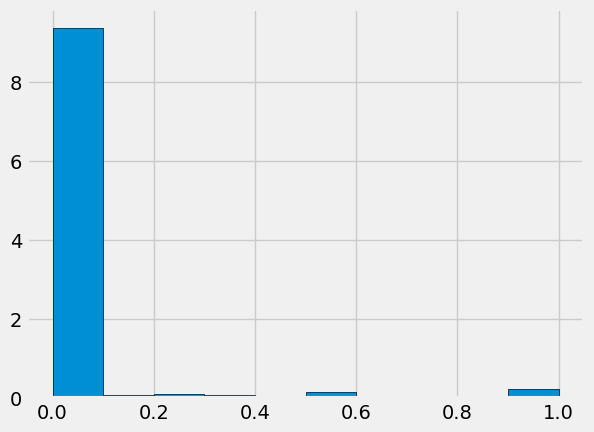

In [348]:
plt.hist(train_df['relevance'], density=True, edgecolor='black')
plt.show()

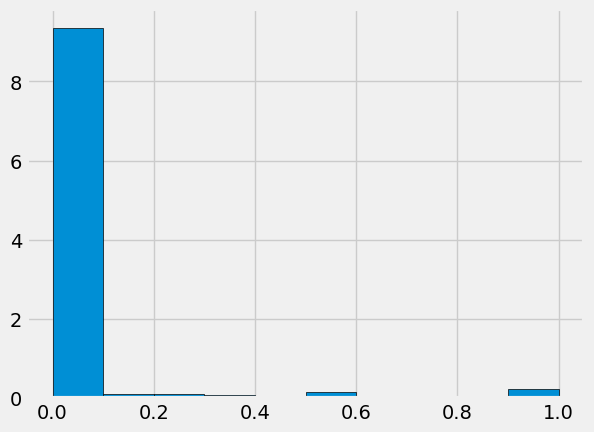

In [349]:
plt.hist(val_df['relevance'], density=True, edgecolor='black')
plt.show()

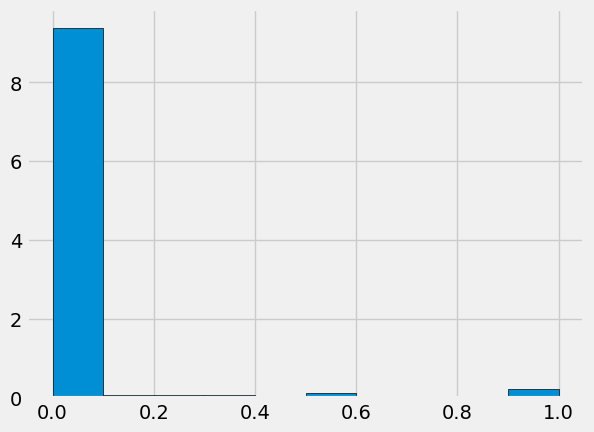

In [350]:
plt.hist(test_df['relevance'], density=True, edgecolor='black')
plt.show()

In [351]:
train_df.head()

,user_id,search_id,point_of_sale,geo_location_country,is_mobile,destination_id,checkin_date,checkout_date,adult_count,child_count,infant_count,room_count,sort_type,length_of_stay,booking_window,search_day_of_week,search_hour_of_day,checkin_day,checkout_day,rank,prop_id,is_travel_ad,review_rating,review_count,star_rating,is_free_cancellation,is_drr,price_bucket,num_clicks,is_trans,rank_noad,AirConditioning,AirportTransfer,Bar,FreeAirportTransportation,FreeBreakfast,FreeParking,FreeWiFi,Gym,HighSpeedInternet,HotTub,LaundryFacility,Parking,PetsAllowed,PrivatePool,SpaServices,SwimmingPool,WasherDryer,WiFi,relevance
30,18,45,4,1,0,639,2021-07-03,2021-07-05,3,1,0,1,RECOMMENDED,2.0,16.0,2,21,5,5,1,1548414,0,4.0,1025.0,3.0,1,0,2.0,0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
31,18,45,4,1,0,639,2021-07-03,2021-07-05,3,1,0,1,RECOMMENDED,2.0,16.0,2,21,5,5,2,3620234,0,4.0,1025.0,3.0,1,1,1.0,0,0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
32,18,45,4,1,0,639,2021-07-03,2021-07-05,3,1,0,1,RECOMMENDED,2.0,16.0,2,21,5,5,3,3520149,0,5.0,1100.0,4.0,1,0,3.0,1,0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
33,18,45,4,1,0,639,2021-07-03,2021-07-05,3,1,0,1,RECOMMENDED,2.0,16.0,2,21,5,5,4,4327136,0,4.0,525.0,4.0,1,0,5.0,0,0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
34,18,45,4,1,0,639,2021-07-03,2021-07-05,3,1,0,1,RECOMMENDED,2.0,16.0,2,21,5,5,5,753664,0,4.0,400.0,4.0,1,0,4.0,0,0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [352]:
train_df.drop(columns=['user_id','checkin_date','checkout_date','num_clicks','is_trans', 'prop_id'], inplace=True)
val_df.drop(columns=['user_id','checkin_date','checkout_date','num_clicks','is_trans', 'prop_id'], inplace=True)
test_df.drop(columns=['user_id','checkin_date','checkout_date','num_clicks','is_trans', 'prop_id'], inplace=True)

train_df.shape, val_df.shape, test_df.shape

<ipython-input-352-ef1cedf99948>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=['user_id','checkin_date','checkout_date','num_clicks','is_trans', 'prop_id'], inplace=True)
<ipython-input-352-ef1cedf99948>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.drop(columns=['user_id','checkin_date','checkout_date','num_clicks','is_trans', 'prop_id'], inplace=True)
<ipython-input-352-ef1cedf99948>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

((126060, 44), (42075, 44), (41846, 44))

In [353]:
X_train_t = train_df.drop(columns=['relevance'])
y_train = train_df['relevance']

X_val_t = val_df.drop(columns=['relevance'])
y_val = val_df['relevance']

X_test_t = test_df.drop(columns=['relevance'])
y_test = test_df['relevance']

query_id_train = X_train_t['search_id']

query_id_val = X_val_t['search_id']

query_id_test = X_test_t['search_id']

In [354]:
object_col = ['point_of_sale', 'geo_location_country', 'is_mobile', 'destination_id','sort_type', 'search_day_of_week','search_hour_of_day', 'checkin_day', 'checkout_day', 'is_travel_ad',
              'review_rating','star_rating','is_free_cancellation', 'is_drr', 'AirConditioning', 'AirportTransfer', 'Bar', 'FreeAirportTransportation', 'FreeBreakfast', 'FreeParking', 'FreeWiFi',
              'Gym', 'HighSpeedInternet', 'HotTub', 'LaundryFacility', 'Parking', 'PetsAllowed', 'PrivatePool', 'SpaServices', 'SwimmingPool', 'SpaServices', 'WasherDryer', 'WiFi']

for i in object_col:
  X_train_t[i]=X_train_t[i].astype('object')

for i in object_col:
  X_val_t[i]=X_val_t[i].astype('object')

for i in object_col:
  X_test_t[i]=X_test_t[i].astype('object')

In [355]:
categorical_features = X_train_t.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train_t.select_dtypes(exclude=['object']).columns.tolist()

numeric_features.remove('search_id')
numeric_features, categorical_features

(['adult_count',
  'child_count',
  'infant_count',
  'room_count',
  'length_of_stay',
  'booking_window',
  'rank',
  'review_count',
  'price_bucket',
  'rank_noad'],
 ['point_of_sale',
  'geo_location_country',
  'is_mobile',
  'destination_id',
  'sort_type',
  'search_day_of_week',
  'search_hour_of_day',
  'checkin_day',
  'checkout_day',
  'is_travel_ad',
  'review_rating',
  'star_rating',
  'is_free_cancellation',
  'is_drr',
  'AirConditioning',
  'AirportTransfer',
  'Bar',
  'FreeAirportTransportation',
  'FreeBreakfast',
  'FreeParking',
  'FreeWiFi',
  'Gym',
  'HighSpeedInternet',
  'HotTub',
  'LaundryFacility',
  'Parking',
  'PetsAllowed',
  'PrivatePool',
  'SpaServices',
  'SwimmingPool',
  'WasherDryer',
  'WiFi'])

In [356]:
combined_df = pd.concat([X_train_t, X_val_t, X_test_t])
combined_df = pd.get_dummies(combined_df, columns=categorical_features)

combined_df.shape

(209981, 750)

In [357]:
X_train = combined_df[:len(X_train_t)]
X_val = combined_df[len(X_train_t):len(X_train_t)+len(X_val_t)]
X_test = combined_df[len(X_train_t)+len(X_val_t):]

X_train.shape, X_val.shape, X_test.shape

((126060, 750), (42075, 750), (41846, 750))

In [358]:
scaler=StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_val[numeric_features] = scaler.transform(X_val[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

<ipython-input-358-a81d6dc2d36b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
<ipython-input-358-a81d6dc2d36b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[numeric_features] = scaler.transform(X_val[numeric_features])
<ipython-input-358-a81d6dc2d36b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

### NN ARCHITECTURE

In [359]:
X_train.head(5)

,search_id,adult_count,child_count,infant_count,room_count,length_of_stay,booking_window,rank,review_count,price_bucket,rank_noad,point_of_sale_1,point_of_sale_2,point_of_sale_3,point_of_sale_4,point_of_sale_5,point_of_sale_6,point_of_sale_7,point_of_sale_8,point_of_sale_9,point_of_sale_10,point_of_sale_11,point_of_sale_12,point_of_sale_13,point_of_sale_14,point_of_sale_15,point_of_sale_16,point_of_sale_17,point_of_sale_18,point_of_sale_20,point_of_sale_21,point_of_sale_22,point_of_sale_24,point_of_sale_25,point_of_sale_26,point_of_sale_27,point_of_sale_29,point_of_sale_31,point_of_sale_32,point_of_sale_33,point_of_sale_34,point_of_sale_35,point_of_sale_36,point_of_sale_38,point_of_sale_39,point_of_sale_40,point_of_sale_41,point_of_sale_42,point_of_sale_44,point_of_sale_45,point_of_sale_47,point_of_sale_48,point_of_sale_49,point_of_sale_50,point_of_sale_51,point_of_sale_54,point_of_sale_57,point_of_sale_59,point_of_sale_60,point_of_sale_65,point_of_sale_72,point_of_sale_75,point_of_sale_86,geo_location_country_1,geo_location_country_2,geo_location_country_3,geo_location_country_4,geo_location_country_5,geo_location_country_6,geo_location_country_7,geo_location_country_8,geo_location_country_9,geo_location_country_10,geo_location_country_11,geo_location_country_12,geo_location_country_13,geo_location_country_15,geo_location_country_16,geo_location_country_17,geo_location_country_18,geo_location_country_19,geo_location_country_20,geo_location_country_21,geo_location_country_23,geo_location_country_24,geo_location_country_25,geo_location_country_26,geo_location_country_27,geo_location_country_28,geo_location_country_29,geo_location_country_30,geo_location_country_31,geo_location_country_32,geo_location_country_33,geo_location_country_34,geo_location_country_35,geo_location_country_36,geo_location_country_37,geo_location_country_38,geo_location_country_39,geo_location_country_40,geo_location_country_41,geo_location_country_42,geo_location_country_43,geo_location_country_44,geo_location_country_45,geo_location_country_46,geo_location_country_47,geo_location_country_50,geo_location_country_52,geo_location_country_53,geo_location_country_54,geo_location_country_55,geo_location_country_56,geo_location_country_58,geo_location_country_65,geo_location_country_66,geo_location_country_68,geo_location_country_69,geo_location_country_71,geo_location_country_77,geo_location_country_78,geo_location_country_80,geo_location_country_81,geo_location_country_82,geo_location_country_84,geo_location_country_86,geo_location_country_89,geo_location_country_90,geo_location_country_91,geo_location_country_92,geo_location_country_96,geo_location_country_98,geo_location_country_99,geo_location_country_102,geo_location_country_103,geo_location_country_114,geo_location_country_115,geo_location_country_116,geo_location_country_130,geo_location_country_146,is_mobile_0,is_mobile_1,destination_id_2,destination_id_3,destination_id_4,destination_id_5,destination_id_6,destination_id_7,destination_id_8,destination_id_9,destination_id_10,destination_id_11,destination_id_12,destination_id_13,destination_id_14,destination_id_15,destination_id_16,destination_id_17,destination_id_18,destination_id_19,destination_id_20,destination_id_21,destination_id_22,destination_id_23,destination_id_24,destination_id_25,destination_id_26,destination_id_27,destination_id_28,destination_id_29,destination_id_30,destination_id_31,destination_id_32,destination_id_33,destination_id_34,destination_id_35,destination_id_36,destination_id_37,destination_id_38,destination_id_39,destination_id_40,destination_id_41,destination_id_42,destination_id_43,destination_id_44,destination_id_45,destination_id_46,destination_id_47,destination_id_48,destination_id_49,destination_id_50,destination_id_51,destination_id_52,destination_id_53,destination_id_54,destination_id_55,destination_id_56,destination_id_57,destination_id_58,destination_id_59,destination_id_60,destination_id_61,destination_id_62,destination

In [360]:
def ndcg_metric_30(y_true, y_pred):
    k = 30  # Assuming you want to compute NDCG@10
    y_score = tf.squeeze(y_pred, axis=-1)  # Assuming y_pred has shape (batch_size, 1)
    y_true = tf.squeeze(y_true, axis=-1)   # Assuming y_true has shape (batch_size,)

    order = tf.argsort(y_score, direction='DESCENDING')
    y_true_sorted = tf.gather(y_true, order)

    gain = tf.pow(2.0, y_true_sorted) - 1.0
    discounts = tf.math.log(tf.range(tf.shape(y_true_sorted)[0], dtype=tf.float32) + 2.0) / tf.math.log(2.0)

    # Compute DCG
    dcg = tf.reduce_sum(gain / discounts)

    # Compute Ideal DCG
    ideal_order = tf.argsort(y_true, direction='DESCENDING')
    ideal_y_true = tf.gather(y_true, ideal_order)[:k]
    ideal_gain = tf.pow(2.0, ideal_y_true) - 1.0
    ideal_dcg = tf.reduce_sum(ideal_gain / discounts[:tf.shape(ideal_gain)[0]])

    # Compute NDCG
    ndcg = tf.where(tf.equal(ideal_dcg, 0), 0.0, dcg / ideal_dcg)
    return ndcg

In [361]:
def ndcg_metric_20(y_true, y_pred):
    k = 20  # Assuming you want to compute NDCG@10
    y_score = tf.squeeze(y_pred, axis=-1)  # Assuming y_pred has shape (batch_size, 1)
    y_true = tf.squeeze(y_true, axis=-1)   # Assuming y_true has shape (batch_size,)

    order = tf.argsort(y_score, direction='DESCENDING')
    y_true_sorted = tf.gather(y_true, order)

    gain = tf.pow(2.0, y_true_sorted) - 1.0
    discounts = tf.math.log(tf.range(tf.shape(y_true_sorted)[0], dtype=tf.float32) + 2.0) / tf.math.log(2.0)

    # Compute DCG
    dcg = tf.reduce_sum(gain / discounts)

    # Compute Ideal DCG
    ideal_order = tf.argsort(y_true, direction='DESCENDING')
    ideal_y_true = tf.gather(y_true, ideal_order)[:k]
    ideal_gain = tf.pow(2.0, ideal_y_true) - 1.0
    ideal_dcg = tf.reduce_sum(ideal_gain / discounts[:tf.shape(ideal_gain)[0]])

    # Compute NDCG
    ndcg = tf.where(tf.equal(ideal_dcg, 0), 0.0, dcg / ideal_dcg)
    return ndcg

In [362]:
def ndcg_metric_10(y_true, y_pred):
    k = 10  # Assuming you want to compute NDCG@10
    y_score = tf.squeeze(y_pred, axis=-1)  # Assuming y_pred has shape (batch_size, 1)
    y_true = tf.squeeze(y_true, axis=-1)   # Assuming y_true has shape (batch_size,)

    order = tf.argsort(y_score, direction='DESCENDING')
    y_true_sorted = tf.gather(y_true, order)

    gain = tf.pow(2.0, y_true_sorted) - 1.0
    discounts = tf.math.log(tf.range(tf.shape(y_true_sorted)[0], dtype=tf.float32) + 2.0) / tf.math.log(2.0)

    # Compute DCG
    dcg = tf.reduce_sum(gain / discounts)

    # Compute Ideal DCG
    ideal_order = tf.argsort(y_true, direction='DESCENDING')
    ideal_y_true = tf.gather(y_true, ideal_order)[:k]
    ideal_gain = tf.pow(2.0, ideal_y_true) - 1.0
    ideal_dcg = tf.reduce_sum(ideal_gain / discounts[:tf.shape(ideal_gain)[0]])

    # Compute NDCG
    ndcg = tf.where(tf.equal(ideal_dcg, 0), 0.0, dcg / ideal_dcg)
    return ndcg

In [363]:
def ndcg_metric_5(y_true, y_pred):
    k = 5  # Assuming you want to compute NDCG@10
    y_score = tf.squeeze(y_pred, axis=-1)  # Assuming y_pred has shape (batch_size, 1)
    y_true = tf.squeeze(y_true, axis=-1)   # Assuming y_true has shape (batch_size,)

    order = tf.argsort(y_score, direction='DESCENDING')
    y_true_sorted = tf.gather(y_true, order)

    gain = tf.pow(2.0, y_true_sorted) - 1.0
    discounts = tf.math.log(tf.range(tf.shape(y_true_sorted)[0], dtype=tf.float32) + 2.0) / tf.math.log(2.0)

    # Compute DCG
    dcg = tf.reduce_sum(gain / discounts)

    # Compute Ideal DCG
    ideal_order = tf.argsort(y_true, direction='DESCENDING')
    ideal_y_true = tf.gather(y_true, ideal_order)[:k]
    ideal_gain = tf.pow(2.0, ideal_y_true) - 1.0
    ideal_dcg = tf.reduce_sum(ideal_gain / discounts[:tf.shape(ideal_gain)[0]])

    # Compute NDCG
    ndcg = tf.where(tf.equal(ideal_dcg, 0), 0.0, dcg / ideal_dcg)
    return ndcg

In [234]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_array), y=y_train_array)
#, class_weight=dict(enumerate(class_weights))

In [364]:
X_train_2 = X_train.drop(columns=['search_id'])
X_train_arr = X_train_2.values.astype(int)
y_train_array = y_train.values.ravel()

X_val_2 = X_val.drop(columns=['search_id'])
X_val_arr = X_val_2.values.astype(int)
y_val_array = y_val.values.ravel()

In [365]:
from tensorflow.keras.layers import Input, Concatenate, Embedding, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2


early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_ndcg_metric_5', mode='max')

np.random.seed(42)
tf.random.set_seed(42)

# Input layers for features and search_id
input_features = Input(shape=(X_train_arr.shape[1],), name='features')
input_query_id = Input(shape=(1,), name='search_id')

# Embedding or concatenation layer for search_id
concatenated_inputs = Concatenate()([input_features, input_query_id])

# Define the rest of your model architecture
dense_layer_1 = Dense(128, activation='relu')(concatenated_inputs)
batch_norm_1 = BatchNormalization()(dense_layer_1)
dense_layer_2 = Dense(512, activation='relu')(dense_layer_1)
dropout_layer = Dropout(0.3)(dense_layer_2)
dense_layer_3 = Dense(1024, activation='relu')(dense_layer_2)
dropout_layer = Dropout(0.3)(dense_layer_3)
dense_layer_4 = Dense(512, activation='relu')(dense_layer_3)
dense_layer_5 = Dense(256, activation='relu')(dense_layer_4)
dense_layer_6 = Dense(128, activation='relu')(dense_layer_5)
dense_layer_7 = Dense(64, activation='relu')(dense_layer_6)
dense_layer_8 = Dense(32, activation='relu')(dense_layer_7)
output_layer = Dense(1, activation='sigmoid')(dense_layer_8)

#Losses
loss_ndcgapprox = tfr.keras.losses.ApproxNDCGLoss(temperature=0.1)
loss_clickeml = tfr.keras.losses.ClickEMLoss()

#Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Define the model
model = Model(inputs=[input_features, input_query_id], outputs=output_layer)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_ndcgapprox, metrics=[ndcg_metric_30, ndcg_metric_20, ndcg_metric_10, ndcg_metric_5])

# Fit the model with both features and search_id
history = model.fit({'features': X_train_arr, 'search_id': query_id_train}, y_train_array,
                    epochs=30, validation_data=({'features': X_val_arr, 'search_id': query_id_val}, y_val_array),
                    verbose=True, batch_size=64, callbacks=[early_stopping_cb])

Epoch 1/30
1970/1970 [==============================] - 32s 15ms/step - loss: -0.0684 - ndcg_metric_30: 0.3153 - ndcg_metric_20: 0.3153 - ndcg_metric_10: 0.3153 - ndcg_metric_5: 0.3202 - val_loss: -0.0718 - val_ndcg_metric_30: 0.3513 - val_ndcg_metric_20: 0.3514 - val_ndcg_metric_10: 0.3524 - val_ndcg_metric_5: 0.3627
Epoch 2/30
1970/1970 [==============================] - 29s 15ms/step - loss: -0.0684 - ndcg_metric_30: 0.3154 - ndcg_metric_20: 0.3154 - ndcg_metric_10: 0.3154 - ndcg_metric_5: 0.3202 - val_loss: -0.0718 - val_ndcg_metric_30: 0.3513 - val_ndcg_metric_20: 0.3514 - val_ndcg_metric_10: 0.3524 - val_ndcg_metric_5: 0.3627
Epoch 3/30
1970/1970 [==============================] - 30s 15ms/step - loss: -0.0684 - ndcg_metric_30: 0.3151 - ndcg_metric_20: 0.3151 - ndcg_metric_10: 0.3151 - ndcg_metric_5: 0.3199 - val_loss: -0.0718 - val_ndcg_metric_30: 0.3513 - val_ndcg_metric_20: 0.3514 - val_ndcg_metric_10: 0.3524 - val_ndcg_metric_5: 0.3627
Epoch 4/30
1970/1970 [==================

### LISTNET LOSS FUNCTION

In [366]:
def listNet(y_pred, y_true, eps=1e-6, padded_value_indicator=-1):
    """
    ListNet loss introduced in "Learning to Rank: From Pairwise Approach to Listwise Approach".
    :param y_pred: predictions from the model, shape [batch_size, slate_length]
    :param y_true: ground truth labels, shape [batch_size, slate_length]
    :param eps: epsilon value, used for numerical stability
    :param padded_value_indicator: an indicator of the y_true index containing a padded item, e.g. -1
    :return: loss value, a tf.Tensor
    """
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.convert_to_tensor(y_true)

    mask = tf.equal(y_true, padded_value_indicator)
    y_pred = tf.where(mask, tf.constant(float('-inf'), dtype=y_pred.dtype), y_pred)
    y_true = tf.where(mask, tf.constant(float('-inf'), dtype=y_true.dtype), y_true)

    # Calculate softmax probabilities
    preds_smax = tf.nn.softmax(y_pred, axis=1)
    true_smax = tf.nn.softmax(y_true, axis=1)

    # Normalize probabilities by sum along the second dimension and multiply by 100 to get percentages
    preds_perc = preds_smax / (tf.reduce_sum(preds_smax, axis=1, keepdims=True) + eps) * 100
    true_perc = true_smax / (tf.reduce_sum(true_smax, axis=1, keepdims=True) + eps) * 100

    # Add epsilon for numerical stability
    preds_perc = preds_perc + eps

    # Calculate logarithm of softmax probabilities
    preds_log = tf.math.log(preds_perc)

    # Compute ListNet loss
    return tf.reduce_mean(-tf.reduce_sum(true_perc * preds_log, axis=1))

### BCE LOSS FUNCTION

In [367]:
def bce(y_pred, y_true, padded_value_indicator=-1):
    """
    Binary Cross-Entropy loss.
    :param y_pred: predictions from the model, shape [batch_size, slate_length]
    :param y_true: ground truth labels, shape [batch_size, slate_length]
    :param padded_value_indicator: an indicator of the y_true index containing a padded item, e.g. -1
    :return: loss value, a tf.Tensor
    """
    mask = tf.equal(y_true, padded_value_indicator)
    valid_mask = tf.not_equal(y_true, padded_value_indicator)

    # Set the loss for padded values to 0
    ls = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_pred, y_true)
    ls = tf.where(mask, 0.0, ls)

    # Calculate document loss and sum of valid instances
    document_loss = tf.reduce_sum(ls, axis=-1)
    sum_valid = tf.reduce_sum(tf.cast(valid_mask, tf.float32), axis=-1) > 0.0

    # Compute the average loss over valid instances
    loss_output = tf.reduce_sum(document_loss) / tf.reduce_sum(tf.cast(sum_valid, tf.float32))

    return loss_output


In [368]:
X_train_2 = X_train.drop(columns=['search_id'])
X_train_arr = X_train_2.values.astype(int)
y_train_array = y_train.values.ravel()

X_val_2 = X_val.drop(columns=['search_id'])
X_val_arr = X_val_2.values.astype(int)
y_val_array = y_val.values.ravel()

In [375]:
from tensorflow.keras.layers import Input, Concatenate, Embedding, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler

X_train_2 = X_train.drop(columns=['search_id'])
X_train_arr = X_train_2.values.astype(int)
y_train_array = y_train.values.ravel()

X_val_2 = X_val.drop(columns=['search_id'])
X_val_arr = X_val_2.values.astype(int)
y_val_array = y_val.values.ravel()

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_ndcg_metric_5', mode='max')

#def lr_scheduler(epoch, lr):
  #  if epoch % 10 == 0 and epoch != 0:
   #     return lr * 0.9
    #return lr

np.random.seed(42)
tf.random.set_seed(42)

# Input layers for features and search_id
input_features = Input(shape=(X_train_arr.shape[1],), name='features')
input_query_id = Input(shape=(1,), name='search_id')

# Embedding or concatenation layer for search_id
concatenated_inputs = Concatenate()([input_features, input_query_id])

# Define the rest of your model architecture
dense_layer_1 = Dense(128, activation='relu')(concatenated_inputs)
dense_layer_2 = Dense(256, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(512, activation='relu')(dense_layer_2)
dense_layer_4 = Dense(256, activation='relu')(dense_layer_3)
dense_layer_5 = Dense(128, activation='relu')(dense_layer_4)
dense_layer_6 = Dense(64, activation='relu')(dense_layer_5)
dense_layer_7 = Dense(32, activation='relu')(dense_layer_6)
output_layer = Dense(1, activation='softmax')(dense_layer_7)

#Losses
loss_ndcgapprox = tfr.keras.losses.ApproxNDCGLoss(temperature=0.1)
loss_listMLE = tfr.keras.losses.ListMLELoss()

#Optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# Define the model
model = Model(inputs=[input_features, input_query_id], outputs=output_layer)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_ndcgapprox, metrics=[ndcg_metric_30, ndcg_metric_20, ndcg_metric_10, ndcg_metric_5])

# Fit the model with both features and search_id
history = model.fit({'features': X_train_arr, 'search_id': query_id_train.values}, y_train_array,
                    epochs=30, validation_data=({'features': X_val_arr, 'search_id': query_id_val.values}, y_val_array),
                    verbose=True, callbacks=[early_stopping_cb])



Epoch 1/30
3940/3940 [==============================] - 29s 7ms/step - loss: -0.0684 - ndcg_metric_30: 0.3079 - ndcg_metric_20: 0.3079 - ndcg_metric_10: 0.3079 - ndcg_metric_5: 0.3082 - val_loss: -0.0718 - val_ndcg_metric_30: 0.3308 - val_ndcg_metric_20: 0.3308 - val_ndcg_metric_10: 0.3318 - val_ndcg_metric_5: 0.3375
Epoch 2/30
3940/3940 [==============================] - 25s 6ms/step - loss: -0.0684 - ndcg_metric_30: 0.3078 - ndcg_metric_20: 0.3078 - ndcg_metric_10: 0.3078 - ndcg_metric_5: 0.3080 - val_loss: -0.0718 - val_ndcg_metric_30: 0.3308 - val_ndcg_metric_20: 0.3308 - val_ndcg_metric_10: 0.3318 - val_ndcg_metric_5: 0.3375
Epoch 3/30
3940/3940 [==============================] - 25s 6ms/step - loss: -0.0684 - ndcg_metric_30: 0.3071 - ndcg_metric_20: 0.3071 - ndcg_metric_10: 0.3071 - ndcg_metric_5: 0.3073 - val_loss: -0.0718 - val_ndcg_metric_30: 0.3308 - val_ndcg_metric_20: 0.3308 - val_ndcg_metric_10: 0.3318 - val_ndcg_metric_5: 0.3375
Epoch 4/30
3940/3940 [=====================

In [370]:
X_train.shape

(126060, 750)

In [371]:
y_train_array

array([0., 0., 1., ..., 0., 0., 0.])

In [372]:
X_train_arr.shape

(126060, 749)

In [373]:
X_test_2 = X_test.drop(columns=['search_id'])  # Remove 'search_id' column if present
X_test_arr = X_test_2.values.astype(int)  # Convert to numpy array
query_id_test_arr = query_id_test.values.reshape(-1, 1)  # Reshape query IDs to match the shape of input_query_id

# Perform predictions on test data
predictions = model.predict({'features': X_test_arr, 'search_id': query_id_test_arr})

# Flatten the predictions if necessary
predictions = predictions.flatten()

len(predictions)

1308/1308 [==============================] - 4s 3ms/step


41846

In [374]:
predictions[:30]

array([0.4973115 , 0.50312966, 0.50573987, 0.50271827, 0.50257343,
       0.50369984, 0.50020885, 0.4997549 , 0.5025304 , 0.498453  ,
       0.50224465, 0.498453  , 0.5005759 , 0.5067911 , 0.49823946,
       0.5042409 , 0.5067575 , 0.49851093, 0.498453  , 0.5006544 ,
       0.50777483, 0.5005372 , 0.501585  , 0.4988465 , 0.5009195 ,
       0.50082254, 0.50444275, 0.49528423, 0.5042213 , 0.506173  ],
      dtype=float32)

In [270]:
def ndcg(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

In [273]:
qids = np.unique(query_id_test)

ndcg_ = list()

for i, qid in tqdm(enumerate(qids[:]), total=len(qids)):
    y = y_test[query_id_test == qid]

    if np.sum(y) == 0:
        continue

    X_test1 = X_test[X_test['search_id'] == qid]
    qid_test = X_test1['search_id']
    X_test1 = X_test1.drop(columns=['search_id'])

    X_test_arr = X_test1.values.astype(int)
    query_id_test_arr = qid_test.values.astype(int)
    query_id_test_arr = query_id_test_arr.reshape(-1, 1)

    predictions = model.predict({'features': X_test_arr, 'search_id': query_id_test_arr}, verbose=False)
    predictions = predictions.flatten()

    idcg = ndcg(y, y, k=5)
    ndcg_.append(ndcg(predictions, y, k=5) / idcg)

np.mean(ndcg_)

100%|██████████| 1548/1548 [02:52<00:00,  8.97it/s]


0.14220305655670604

In [285]:
ks = ['K5', 'K10', 'K20', 'K30']

scratch_nn_sdg = [0.14, 0.21, 0.27, 0.39]
nn_allrank = [0.22, 0.28, 0.36, 0.42]
xgboost_ndcg = [0.562, 0.62, 0.66, 0.67]
lightgbm_ndcg = []

original_df = [0.47, 0.51, 0.57, 0.61]

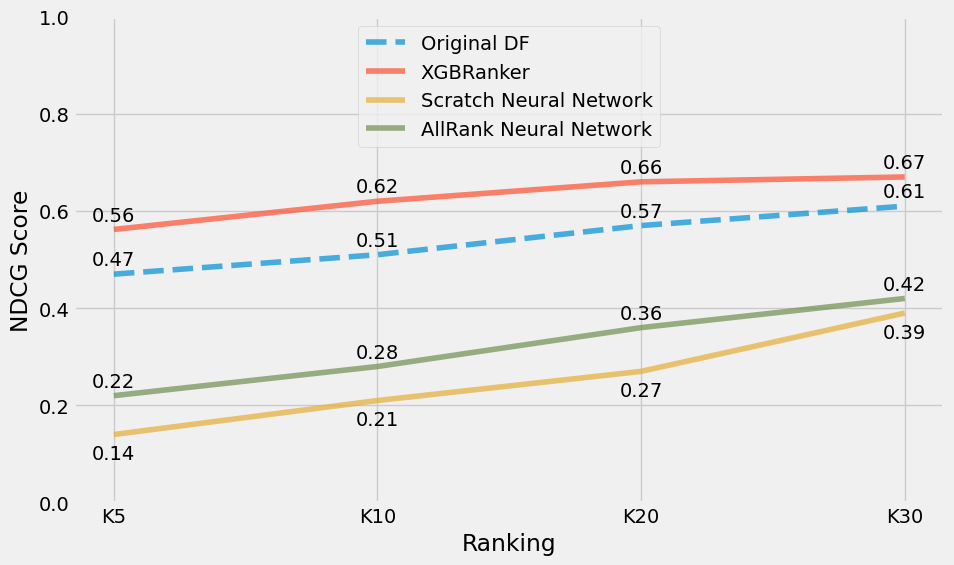

In [322]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6))

plt.plot(ks, original_df, label='Original DF', alpha=0.7, linestyle='--')
plt.plot(ks, xgboost_ndcg, label='XGBRanker', alpha=0.7)
#plt.plot(ks, lightgbm_ndcg, label='LGBMRanker', alpha=0.7)
plt.plot(ks, scratch_nn_sdg, label='Scratch Neural Network', alpha=0.7)
plt.plot(ks, nn_allrank, label='AllRank Neural Network', alpha=0.7)

for i, (x, y) in enumerate(zip(ks, original_df)):
    plt.text(x, y+0.01, f'{y:.2f}', ha='center', va='bottom')

for i, (x, y) in enumerate(zip(ks, xgboost_ndcg)):
    plt.text(x, y+0.01, f'{y:.2f}', ha='center', va='bottom')

#for i, (x, y) in enumerate(zip(ks, lightgbm_ndcg)):
 #   plt.text(x, y, f'{y:.2f}', ha='right', va='bottom')

for i, (x, y) in enumerate(zip(ks, scratch_nn_sdg)):
    plt.text(x, y-0.02, f'{y:.2f}', ha='center', va='top')

for i, (x, y) in enumerate(zip(ks, nn_allrank)):
    plt.text(x, y+0.01, f'{y:.2f}', ha='center', va='bottom')

plt.title('')
plt.ylabel('NDCG Score')
plt.xlabel('Ranking')
plt.legend(loc='upper center')
plt.ylim(0,1)
plt.show()

In [ ]:
df_amenities.groupby('search_id').count()

In [ ]:
len(ndcg_), len(qids)

(1548, 1548)

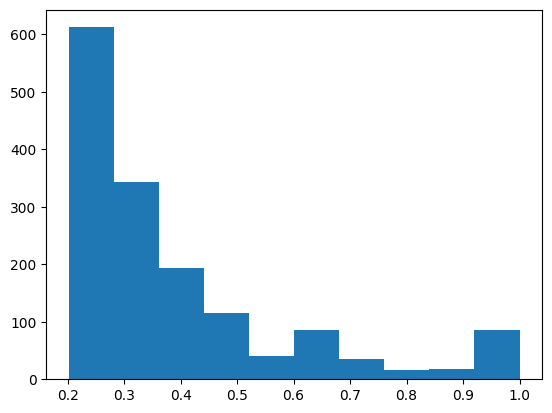

In [ ]:
plt.hist(ndcg_)
plt.show()

### EVALUATION TRAIN AND VAL LOSS

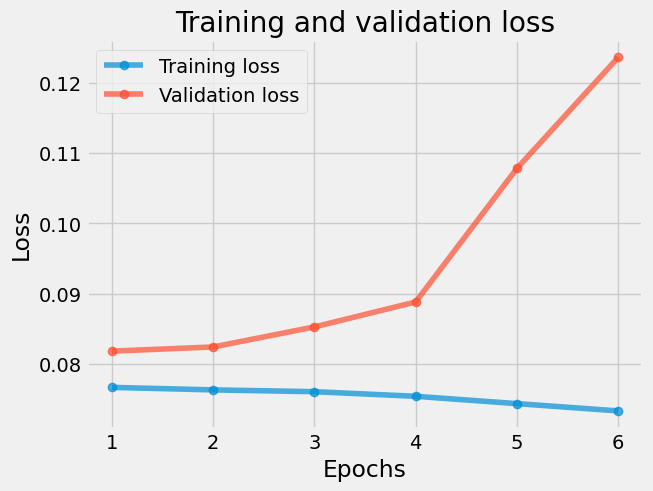

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.style.use('fivethirtyeight')
plt.plot(epochs, train_loss, label='Training loss', marker='o', alpha=0.7)
plt.plot(epochs, val_loss, label='Validation loss', marker='o', alpha=0.7)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### TEST PREDICTIONS AND EVALUATION

In [ ]:
X_test_2 = X_test.drop(columns=['search_id'])
X_test_arr = X_test_2.values.astype(int)
y_test_array = y_test.values.ravel()

test_loss = model.evaluate(X_test_arr, y_test_array)

predictions = model.predict(X_test_arr.astype(float))

predictions = predictions.reshape(-1)

test_df['predicted_score'] = predictions

y_test_df = pd.DataFrame({'relevance_score': y_test, 'predicted_ranking': predictions})
y_test_df.head()

1308/1308 [==============================] - 2s 1ms/step


<ipython-input-358-c8c51102caab>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_score'] = predictions


,relevance_score,predicted_ranking
0,1.0,0.117271
1,0.0,0.120173
2,0.0,0.103796
3,0.0,0.161382
4,0.0,0.111887


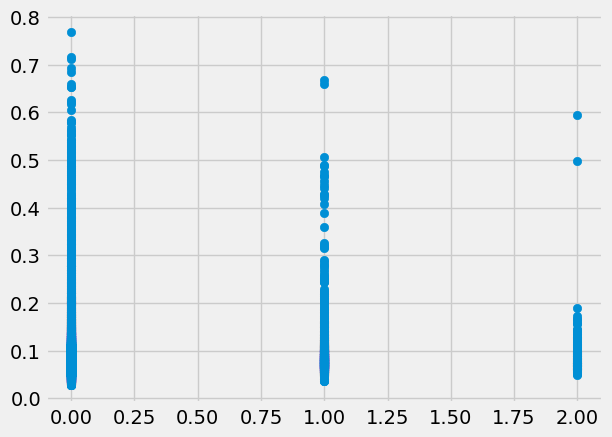

In [ ]:
plt.style.use('fivethirtyeight')
plt.scatter(y_test_df["relevance_score"], y_test_df["predicted_ranking"])
plt.show()

In [ ]:
print('Mean predicted score for 0 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 0]['predicted_ranking']))
print('Mean predicted score for 1 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 1]['predicted_ranking']))
print('Mean predicted score for 2 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 2]['predicted_ranking']))
print('Mean predicted score for 3 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 3]['predicted_ranking']))

Mean predicted score for 0 relevance values: 0.081629366
Mean predicted score for 1 relevance values: 0.0882183
Mean predicted score for 2 relevance values: 0.08923919
Mean predicted score for 3 relevance values: nan


In [ ]:
ndcg_noad_nn_all = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)
    ndcg = ndcg_score([true_labels], [pred_scores])
    ndcg_noad_nn_all.append(ndcg)

print('NDCG mean taking into account all values of the ranking', np.mean(ndcg_noad_nn_all))

NDCG mean taking into account all values of the ranking 0.32403404957409676


In [240]:
ndcg_noad_nn_k20 = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'].reverse=True)
    ndcg = ndcg_score([true_labels], [pred_scores], k=20)
    ndcg_noad_nn_k20.append(ndcg)

print('NDCG mean taking into account the first 20 values of the ranking', np.mean(ndcg_noad_nn_k20))

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (<ipython-input-240-a38f4a5061a6>, line 4)

### NDCG EVALUATION ORIGINAL DATASET

In [237]:
df_amenities.shape

(209981, 50)

In [243]:
ndcg_df_k30 = []
for group_name, group_df in tqdm(df_amenities.groupby('search_id'), total=len(df_amenities.groupby('search_id'))):
    pred_scores = group_df['relevance']
    true_labels = sorted(group_df['relevance'], reverse=True)
    ndcg = ndcg_score([true_labels], [pred_scores], k=30)
    ndcg_df_k30.append(ndcg)

print('NDCG mean taking into 30 first values of the ranking', np.mean(ndcg_df_k30))

100%|██████████| 7739/7739 [00:05<00:00, 1420.70it/s]

NDCG mean taking into account all values of the ranking 0.6110102050442456


In [246]:
ndcg_df_k20 = []
for group_name, group_df in tqdm(df_amenities.groupby('search_id'), total=len(df_amenities.groupby('search_id'))):
    pred_scores = group_df['relevance']
    true_labels = sorted(group_df['relevance'], reverse=True)
    ndcg = ndcg_score([true_labels], [pred_scores], k=20)
    ndcg_df_k20.append(ndcg)

print('NDCG mean taking into 30 first values of the ranking', np.mean(ndcg_df_k20))

100%|██████████| 7739/7739 [00:06<00:00, 1287.35it/s]

NDCG mean taking into 30 first values of the ranking 0.5670903760620734


In [244]:
ndcg_df_k10 = []
for group_name, group_df in tqdm(df_amenities.groupby('search_id'), total=len(df_amenities.groupby('search_id'))):
    pred_scores = group_df['relevance']
    true_labels = sorted(group_df['relevance'], reverse=True)
    ndcg = ndcg_score([true_labels], [pred_scores], k=10)
    ndcg_df_k10.append(ndcg)

print('NDCG mean taking into 30 first values of the ranking', np.mean(ndcg_df_k10))

100%|██████████| 7739/7739 [00:05<00:00, 1389.10it/s]

NDCG mean taking into 30 first values of the ranking 0.5091559496700473


In [245]:
ndcg_df_k5 = []
for group_name, group_df in tqdm(df_amenities.groupby('search_id'), total=len(df_amenities.groupby('search_id'))):
    pred_scores = group_df['relevance']
    true_labels = sorted(group_df['relevance'], reverse=True)
    ndcg = ndcg_score([true_labels], [pred_scores], k=5)
    ndcg_df_k5.append(ndcg)

print('NDCG mean taking into 30 first values of the ranking', np.mean(ndcg_df_k5))

100%|██████████| 7739/7739 [00:05<00:00, 1417.34it/s]

NDCG mean taking into 30 first values of the ranking 0.4671252940756778
